# TITLE CELL

OVERALL, EXPLAIN CODE SNIPPETS, have them interact with the rest of the algorithms, and explain the overall approach.

## The environment

Description of the environment, the task, reward, the MARL setting...   


The problem illustrated in this notebook is a Multi-Agent Reinforcement Learning (MARL) consisting of 2 players playing one against the other at a game called Connect 4. Connect 4 is a two-player game. The goal is to get 4 tokens aligned horizontally, vertically or diagonaly. The token are placed turn by turn and fall vertically until the bottom or another token. If the grid is full and nobody won, the game is a draw. The grid is a rectangle 7 cells wide and 6 cells high. The observation space is a 6*7 matrix filled with 1 if the agent has token on this cell and 0 if either nobody or the other agent has a token on this cell. The action space is an interger between 0 and 6 included that indicates on each column to drop a token.  

The reward is +1 for a win, 0.5 for a draw and 0 for a loss.




## 1. First Ingredient: Tree Search

### 1.1 Deterministic Tree Search: from DFS to Alpha-Beta Pruning


Given a certain state of the grid, we can compute all the possible positions with each action we can take. Then we can do the same for each action of the oppenent. This way, we can build a tree with each node representing the state of the board and the edges an action taken. A naive solution would be to explore all the tree until a certain depth. This algorithm thus works by taking the This method called Breadth-First Search (BFS) is simple to implement but is both memory and computation expensive as the number of nodes is multiplied by 7 at each depth. If we compute a single combination of moves from the node until the end, we obtain the Depth-First Search (DFS). In this case, to compute the value at each node we proceed according to the following way : if it is a terminal node, we assign a value of & in case of a win, 0.5 for a draw and 0 for a less. For non terminal nodes, if it is the agent's turn we take the maximum value among its children. If it is the oppenent's turn, we take the minimum value. It requires less memory compared to BFS but it may waste a lot of time exploring unpromising branches. A way to solve this problem is a method called Alpha-Beta Pruning. 


#### 1.1.A The Minimax Algorithm, a version of DFS

The goal of the Minimax Algorithm is to find the best move for the current player in a zero-sum **deterministic** game. The current player is the maximizer and tries to maximize its own score/reward and the other player is the minimizer and tries to minimize the score/reward of the maximizer (thus maximizing its own score/reward). Each state (node) in the tree is fully expanded until a leaf node (terminal state) is reached. The value of an action is computed by the minimax formula:

$$
V(s) = \begin{cases}
R(s) & \text{if } s \text{ is a terminal state} \\

\max_{a \in \mathcal{A}(s)} V(\text{result}(s, a)) & \text{if } \text{player}(s) = \text{maximizer} \\
\min_{a \in \mathcal{A}(s)} V(\text{result}(s, a)) & \text{if } \text{player}(s) = \text{minimizer} \\
\end{cases}
$$

Where $\mathcal{A}(s)$ is the set of legal actions that can be taken from state $s$, $\text{result}(s, a)$ is the state resulting from taking action $a$ in state $s$, $\text{player}(s)$ is the player that has to play in state $s$ and $R(s)$ is the reward of state $s$. All of these functions are clearly defined in a fully observable deterministic game like Connect 4, Chess, Tic-Tac-Toe, Go, etc...

To compute the value of each state, we have to use a Depth-First Search (DFS) algorithm and backpropagate the value of leaf nodes to the root node, which is the current state of the game (although technically, minimax only needs to traverse the full tree from the starting state once and the game is "solved" for perfect play). However, this algorithm is not efficient as it explores the full tree and is thus not scalable to games with a high branching factor and/or depth. It also would not work in partially observable or stochastic environments. 

#### 1.1.B Alpha-Beta Pruning, improving the Minimax Algorithm and the use of heuristics.


Alpha-Beta Pruning is a way to improve the Minimax Algorithm by pruning branches that are guaranteed to be worse than the current best move. This is done by keeping track of two values, alpha and beta, which represent the minimum score the maximizer is assured of and the maximum score the minimizer is assured of respectively. When the algorithm finds a move that is better than the current alpha or beta, it updates the value and prunes the other branches and when the move under consideration is worse (for the current player) than the current alpha or beta, it prunes the branch. This way, the algorithm is able to expand a smaller number of nodes and thus is stricly more efficient than Minimax. The gap of performance between Minimax and Alpha-Beta Pruning depends a lot on the ordering of moves/actions to take when expanding a node. Considering a suboptimal move first will not allow the algorithm to prune as many branches as if it had considered the optimal move or a close-to-optimal move first.

Because even Alpha-Beta Pruning can be very computationally expensive, most modern game engines like Stockfish (for Chess) in high branching factor cannot explore the full tree until leaf nodes, even with pruning. Instead of relying on game results/rewards at the leaf node, game engines use heuristics (or even function approximations) to estimate the value of a state. In turn, the pruning is done not when an actual reward is "received" in a branch, but when the heuristics that are computed are worse than the current alpha or beta. Heuristics are also used for move ordering, as a good ordering can lead to more pruning and thus a faster search.

For example, in chess, heuristics can be the number and value of pieced on the board, a passed pawn, the control of the center, a knight's outpost (or conversely, a knight that is trapped on the edge of the board), etc... In Connect 4, a heuristic could be the number of 3-in-a-row positions, the number of 2-in-a-row positions and whether they are "open" on either end. Rules for these heuristics are often hand-crafted by experts in the game (similarly to hand-crafting features in the early days of function approximations in ML/RL) and then these heuristics are combined into a single value that represents the value of the state, either with hand-crafted weights or with some form of linear regression. This was the base of the pruning method used in Stockfish (in conjunction with alpha-beta search) until recent versions. 

In 2019/2020, Neural Networks were added to Stockfish to improve the evaluation heurisitcs, moving it closer to AlphaZero's approach (but with a very different search algorithm and training method). 

### 1.2 Monte-Carlo Tree Search (MCTS)

Monte-Carlo Tree Search (MCTS) is a alternative tree search algorithm that can be used in games where the full tree cannot be explored and standard deterministic pruning would also be very expensive. MCTS is a probabilistic tree search algorithm that uses random simulations (rollouts) to estimate the value of a state. As we will see, MCTS is closely related to the Upper Confidence Bound (UCB) algorithm, which is used to balance exploration and exploitation in the tree search, but necessitate additional elements to take into account the multitude of states and the temporal dimension of games (plus the MARL setting) as opposed to the simple bandit setting of UCB.

#### 1.2.A Naive MCTS: the UCT Algorithm



Monte-Carlo tree search (MCTS) is a heuristic search algorithm that is used in games with a high branching factor and/or depth. It is based on the principle of Monte-Carlo simulation to estimate the value of any state in the game. For deep or high branching games, one need to be smart about how to explore the tree and how much time to spend expanding the reccuring results of an action. UCT, a version of MCTS that is a simplified version of AlphaGo/AlphaZero's MCTS, is a good starting point to understand the algorithm. UCT stands for Upper Confidence Bound for Trees. It assumes no prior knowledge of the game, appart from legal moves and terminal states (so the rules of the game). 

1. The tree is initialized with a single root node, the starting (or current) state of the game $s_0$. Every action we eventually take will be an edge in the tree and every state we reach will be a node in the tree.

2. We compute rollouts starting at the root node. A rollout is a simulation of the game from the current state to a terminal state. The result of the rollout is the reward of the game. This value is then backpropagated to the root node. More precisely, when encoutering a state for the first time, we initialize a Q value and visit count vectors for each legal action. The Q value is the average reward of the rollouts that passed through this action and the visit count is the number of times this action was taken. When encountering a state that has already been visited, we select the action with the highest UCB value, which is a trade-off between exploitation (in this case expanding the search in the most promising direction so far) and exploration (in this case exploring a new action that has not been taken much yet). The UCB value is computed as follows:

$$
UCB = Q(s, a) + c \times \sqrt{\frac{\log N(s)}{N(s, a)}},
$$

where $c$ is a hyper-parameter controlling the exploration/exploitation trade-off.

3. After a given exploration budget, the algorithm returns either the action at the root node with the highest Q value or the action with the highest visit count (variants exist with stochastic policies that are soft maximas of the visit counts or values).

Essentially, MCTS is a probabilistic pruning algorithm that uses random simulations to estimate the value of a state and stops the search down a certain action when it is really unlikely to be the best action. Reusing the child tree for the chosen action is also a good idea to save computation time and start the next search with a better expansion policy.

*Variants exist that only consider states and not actions in the UCB formula, because, for deterministic games, it's equivalent. Different implementations for AlphaZero and its successors have different standards*

#### 1.2.B MCTS with a prior policy


Going one step closer to AlphaZero, we can add heuristics to the rollouts of MCTS. This can be useful when the game is still too complex or too large for random simulations to produce reasonnable low variance estimates of the value of a state.

Our first heuristic that we are going to add is a prior on actions... i.e. a base exploration policy that can be non uniform. For example in chess, such a policy could prioritize capturing pieces, and moving the king to safety. In Connect 4, we could prioritize actions that lead to 3-in-a-row positions. This is a way to guide the search towards more promising actions and therefore avoid expanding the tree in directions that are unlikely to be fruitful.

We replace the UCB formula with the following formula:

$$
PUCB = \bar{Q}(s, a) + c \pi(a|s) \sqrt{\frac{N(s)}{1+N(s, a)}},
$$

where $\pi(a|s)$ is the prior probability of taking action $a$ in state $s$ and $c$ is the exploration parameter, controlling both the exploration/exploitation trade-off and the influence of the prior at the same time. For a high value of $c$, as long as the node has not been visited much and no substantial reward has been received, the prior will have a strong influence on the UCB value. Calling $\pi(a|s)$ a prior is a bit misleading, as it is not a prior in the Bayesian sense and even for high values of $c$, we will not sample from the prior initially, but rather take the argmax of the UCB value.

To ensure that the prior actually matters, $Q(s,a)$ are usually replaced with $\bar{Q}(s,a)$, which normalizes the Q values of the actions in state $s$ to be between 0 and 1. This implementation detail is present in almost all implementations of Alpha(Go) Zero and its successors.

Note also that AlphaGo has no $\sqrt{N(s)}$ term in the fraction and simply states that the bonus is "proportional" to the prior divided by the visit count, which is fairly equivalent (up to the varying impact of increasing visit count to the parent node and different optimal values for the hyper-parameter $c$). AlphaZero makes use of this specific formulation.

#### 1.2.B MCTS with fast rollouts

For very deep games, computing recursively UCT values until a leaf node, might be too expensive. In cases like that, instead of full UCT computations, the tree is traversed, starting at a certain depth, with a rollout policy, during a step called simulation. This policy can be a simple heuristic, a neural network...If it is sufficiently cheap, several rollouts/simulations can be done for each node at the limit depth in the tree. As we will see later with AlphaGo and function approximation, the rollout policy was a smaller neural network than the full policy, trained on the same initial data as the full policy.

The performance of MCTS in this case is very dependent on the quality of both the base rollout policy and (when used) of the fast rollout policy.

#### 1.2.B MCTS with a value heuristics

Similarly to simplifying the policy for lowering the computational cost, another way of avoiding to expand unpromising nodes is to add value heuristics (or state-value) heuristics to our tree search. (We are getting very close to AlphaGo here!). This can be especially useful when rollout of the games have high variance, or when they are unreliable in the early stages of the game. These heuristics are the same as the ones used in Alpha-Beta pruning, but are used in a different way. Instead of pruning the tree when the heuristic is worse than the current alpha or beta, the heuristic is incorporated in the Q values for the UCB formula:

$$
Q(s, a) = (1 - \lambda) Q_{\text{rollout}}(s, a) + \lambda V(s),
$$

where $Q_{\text{rollout}}(s, a)$ is the former Q value (average reward of the rollouts, both with search and the fast rollout policy) and $V(s)$ is the value heuristic of state $s$. $\lambda$ is a hyper-parameter controlling the influence of the value heuristic that the authors of AlphaGo called the mixing parameter.

Even when there is no fast rollout policy (as in AlphaGo Zero, AlphaZero...), i.e. nodes are always expanded until the leaf node, value heuristics remain very useful in resource constrained exploration, when the number of allowed expansions is limited (timed competition) because it takes more into account unexplored states.

## 2.Second Ingredient: Function Approximation

### 2.1 The different networks in AlphaGo and their training

There are three main neural networks in AlphaGo and two in AlphaZero and three again for MuZero/GumbelMuZero.

For AlphaGo we have:
- a policy network
- a value network 
- a fast rollout policy "network"

Instead of hand-crafted heuristics or handcrafted features combined with linear regression/a very small network learned with traditional RL, the first two networks are Convolutional Neural Networks (CNNs) and they have very little domain knowledge of the game. In AlphaGo, the input features were the raw board positions but also liberties (number of empty cells around a stone) and other board related features. Some of these could be considered hand-crafted features but they are very close to the actual rules of the game and not the result of human expertise choosing specific, complex patterns.

The third "network", the fast rollout policy, contained, for AlphaGo,hand-crafted features both related to GO positions. In addition, the fast rollout policy makes use of similarities between future states and potential states that were already visited in the tree search (so the part that was guided by the higher quality policy and the search algorithm).  


The policy network is first trained to replicate human expert moves. This is done by supervised learning on a dataset of human games. 



### 2.2 Differences between AlphaGo and AlphaZero



### Use of a value network and policy network in MCTS: the first step in AlphaGo

Show that a poorly trained value network/policy network are improved by MCTS :
- show that value estimates are improved by MCTS
- show that policy estimates are improved by MCTS (compared to depth 0)

Why MCTS and not alpha-beta pruning? --> avoid accumulation of errors.

Fast rollout policy from human experts (without TS) just for the end + combine with values.

### How to train these networks (for the first step in AlphaGo)

## 3. Third Ingredient: Self-Play

The third ingredient of AlphaZero is self-play, which is a form of **background planning**. This technique was already used in algorithms like TD-Gammon, and AlphaGo, albeit in two different ways. Specifically, the policy of AlphaGo was first trained on human data, and then improved through self-play against the best policy among every previous iterations. AlphaGo Zero, AlphaZero and every subsequent algorithm using the same architecture, however, only use self-play to train the policy and value networks.


### How to generate training data

During training of Alpha(Go) Zero, the agent continuously plays games against itself using MCTS, the same algorithm used during the decision time, but here used for background planning. Using the current policy-value network pair to guide the search, the agent plays games until the end. It stores, in each visited state (state that was actually reached during the game), the final search probabilities for that state $\pi_\mathrm{PUCT}$. In the end, a reward (1 for a win, 0.5 for a draw, 0 for a loss) is assigned to the whole game trajectory. 

For Alpha(Go) Zero, this training data is generated asynchronously by multiple instances of the agent playing games against itself (and with multiple threads per instance for MCTS), and stored in a replay buffer, while the network is trained on mini-batches of this data in parallel. The replay buffer here plays a slightly different role than in DQN training, as it's role is not to stabilize the training by breaking the temporal correlation between samples and collecting more diverse data, but rather just to store the asynchronous data.


### Variants of Self-Play

In our implementation, we explored two distinct self-play variants in addition to the normal version of AlphaZero to assess their effectiveness and impact on training dynamics: Frozen Opponent and Versus All.

#### Frozen Opponent

In this variant, after a predetermined iteration, the opponent model is ‘frozen,’ meaning its parameters are no longer updated. Subsequent games are played against this fixed version of the opponent.

The idea behind this variant is to see the consequences of training AlphaZero in a static environment. This static environment will be more stable than the usual, but it also means that it is sufficient for the agent to find a strategy that is optimal against the current opponent, rather than a strategy that is optimal against all possible opponents. This can lead to some sort of collapse as the agent overfits against a certain behavior.

#### Versus All

In the Versus All variant, the agent generates training data by playing against all previously trained versions of itself, sampled uniformly. By including a diverse set of opponents from every iteration, this method aims to produce a more robust and generalizable policy. It exploits the fact that we have a set of agents with different policies, gives more diversity in the self-play data. The agent is forced to adapt to a variety of strategies and will perhaps generalize better to new opponents. The training might be slower but the final policy could be more robust.


### How to train the networks: AlphaGo vs Alpha(Go) Zero

There are important differences in how the networks are trained with self play in AlphaGo and Alpha(Go) Zero, apart from the fact that AlphaGo first used human data to train the policy network. 

AlphaGo's self play improvement was done using a vanilla policy gradient algorithm (REINFORCE) without any baseline (so without using the value network). In fact, the value network was only trained at the end of the policy improvement phase, using just self-play games of the final agent. This value network was then used, in conjunction with the fast rollout policy to improve the search in MCTS-PUCT.

In Alpha(Go) Zero, the training objective for the policy is different. Instead of a policy gradient, or an advanced version like Actor Critic (making use of the value network being trained alongside the policy network), the policy is trained to match the final search probabilities $\pi_\mathrm{PUCT}$ obtained from MCTS-PUCT in every state. This is done by minimizing the KL divergence/cross entropy. There are several advantages of this approach. First, it is more stable and less noisy than policy gradients (because the full vector of probabilities is used, instead of just the value of the actions being taken). Second, it is more sample efficient, as information from states that ended up being not chosen is still used to train the policy. This is better both for other potential good moves that were not chosen, and for quickly pushing down the probabilities of bad moves that could have been chosen (but weren't). In effect, Alpha(Go) Zero's policy training continuously distills the search knowledge into the policy network, making it more and more accurate over time. The final policy, even without search (depth 0), is often very strong. In our Connect 4 example, it would probably beat you. [CODE]

In [1]:
# TODO add example

In both AlphaGo and Alpha(Go) Zero, the value network is trained using the final outcome of the game, without considering Q-values that were computed during the game by MCTS-PUCT (which would have been a form of bootstrapping/temporal difference learning). In zero-sum games with reward $\pm 1$, this is equivalent to training the value network to predict the probability of winning from a given state.

To conclude, Alpha Zero's training can be seen as on-policy, with some nuances. The value network is definitely trained on-policy, as it is trained on the final outcome of the game and nothing else. As for the policy network, one could argue for both cases (on and off-policy). Technically, the target policy that the network is trained to match is the search probabilities $\pi_\mathrm{PUCT}$, which are obtained from the current policy-value network pair and MCTS, not just the raw policy network. However, this policy network is not supposed to be used on its own, but rather in conjunction with MCTS, so one would argue that the combination (policy network + MCTS) is trained on-policy.

A small caveat to all of that is the use of the replay buffer. However, the replay buffer is quite shallow and provides only data from very recent games. It is also used to make the training asynchronous between network improvements and self-play rollout generation. We would tag Alpha Zero's training as *mildly off-policy*.

## Result! AlphaZero

### Describe AlphaZero
decition time planning with MCTS, background planning with self-play, and the use of deep neural networks.

Show a complete training

### Variants (MuZero, Gumbel MuZero, other like Efficient Zero?)

### Implementation

For all training runs, we used a ResNet architecture for the shared policy and value network, with a depth of 5 residual blocks. Training was conducted over 20 iterations, with each iteration consisting of 12,800 self-play games. The number of simulations per move is set to 32. 

For the implementation of the frozen approach, the opponent model was frozen at iteration 10, and all subsequent self-play games were conducted against this static model.

For the versus all approach, the agent played against all previously trained models, with opponents uniformly sampled from earlier iterations.

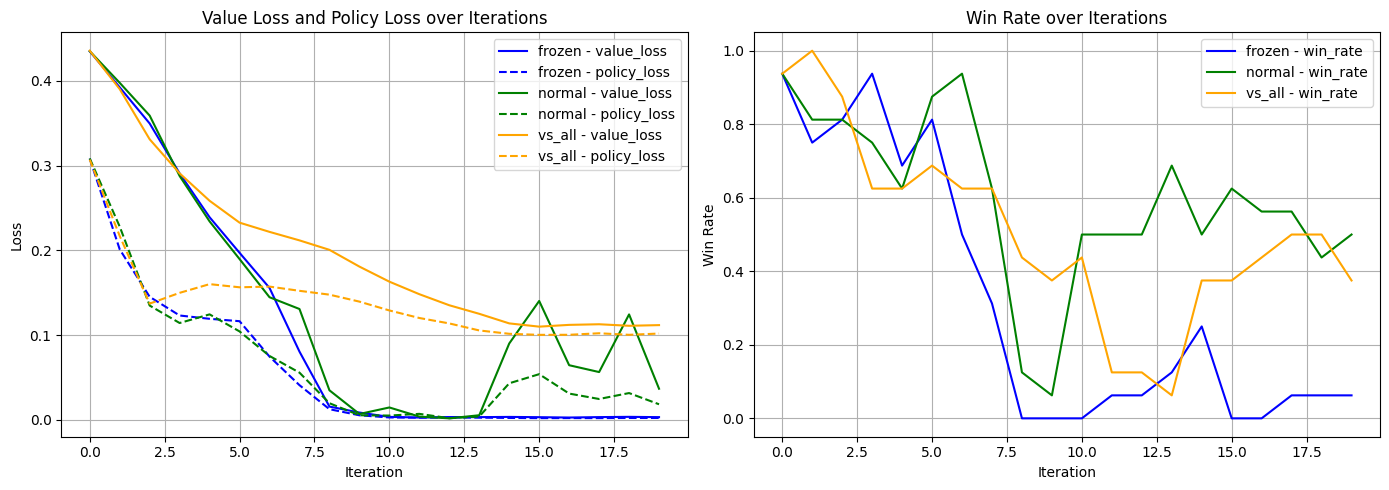

In [34]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Base directory for all logs
base_dir = "all_models"
subdirs = ["frozen", "normal", "vs_all"]
colors = {"frozen": "blue", "normal": "green", "vs_all": "orange"}

# Helper function to load logs
def load_logs(subdir):
    file_path = os.path.join(base_dir, subdir, "training_log.csv")
    if os.path.exists(file_path):
        return pd.read_csv(file_path)
    else:
        print(f"Warning: {file_path} does not exist.")
        return None

# Fetch logs
logs = {}
for subdir in subdirs:
    logs[subdir] = load_logs(subdir)

# Plotting function
def plot_logs(logs, subdirs):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Value loss and Policy loss plot
    for subdir in subdirs:
        if logs[subdir] is not None:
            axes[0].plot(
                logs[subdir]['iteration'], 
                logs[subdir]['value_loss'], 
                label=f"{subdir} - value_loss", 
                color=colors[subdir], 
                linestyle="-"
            )
            axes[0].plot(
                logs[subdir]['iteration'], 
                logs[subdir]['policy_loss'], 
                label=f"{subdir} - policy_loss", 
                color=colors[subdir], 
                linestyle="--"
            )

    axes[0].set_title("Value Loss and Policy Loss over Iterations")
    axes[0].set_xlabel("Iteration")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    axes[0].grid(True)

    # Performance metrics plot
    for subdir in subdirs:
        if logs[subdir] is not None:
            total_games = logs[subdir]['wins'] + logs[subdir]['draws'] + logs[subdir]['losses']
            win_rate = logs[subdir]['wins'] / total_games
            axes[1].plot(
                logs[subdir]['iteration'], 
                win_rate, 
                label=f"{subdir} - win_rate", 
                color=colors[subdir]
            )

    axes[1].set_title("Win Rate over Iterations")
    axes[1].set_xlabel("Iteration")
    axes[1].set_ylabel("Win Rate")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# Plot logs
plot_logs(logs, subdirs)

Learning stops for the frozen model, which is coherent with the fact that the objective becomes static, whereas it is changing for other models since the opponent improves.

For other models, we see that the losses go down steadyly but never to 0. Also, the win rates against the previous iterations stay positive, which means that the agents are always beating the previous versions of themselves. This is a good sign that the agents are learning and improving over time.

# Tournament

To evaluate the performance of the trained agents, we conducted a round-robin tournament. Each agent -- each iteration of each method -- played a match of 16 games against every other agent. Matches were played with each agent starting as both player 1 and player 2 to ensure fairness. As in training, agents were using 32 simulations per move. This is a parameter that could be changed and it could also be interesting to see how the performance changes if we set this number to 0, to see how the policy network performs on its own, without any decision time planning.

The outcomes of the tournament were recorded as win-draw-loss ratios and used to compute Elo ratings for each agent. This provided a comparative measure of performance across all training variants and iterations. Then, the Elo ratings are computed on a shuffled list of matches.

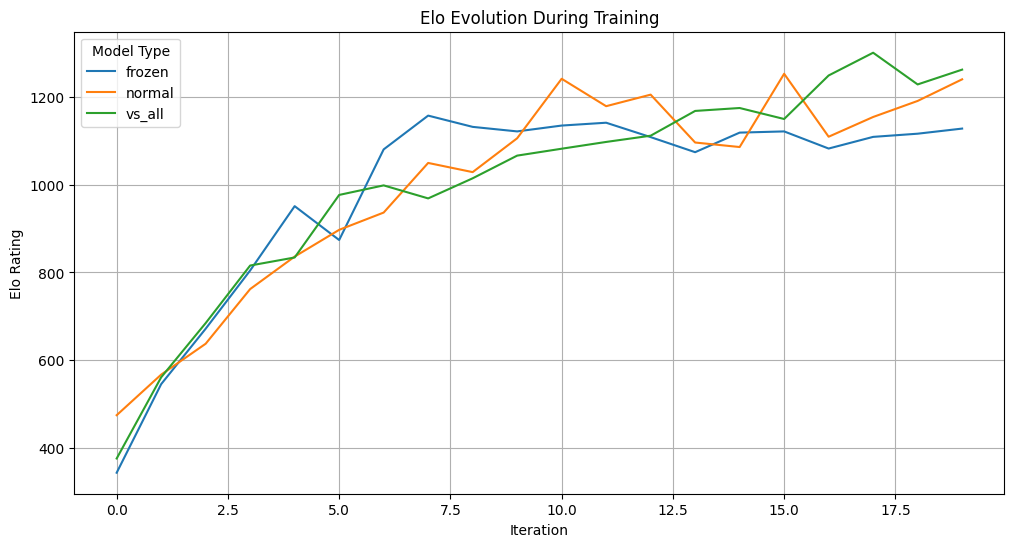

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load Elo ratings data
elo_data = pd.read_csv("elo_ratings.csv")

# Extract model type and iteration from file path
elo_data['model_type'] = elo_data['player'].apply(lambda x: x.split('/')[2])
elo_data['iteration'] = elo_data['player'].apply(lambda x: int(x.split('_')[-1]))

# Sort data by model type and iteration
elo_data = elo_data.sort_values(by=['model_type', 'iteration'])

# Plot
plt.figure(figsize=(12, 6))
for model_type, group in elo_data.groupby('model_type'):
    plt.plot(group['iteration'], group['elo'], label=model_type)

plt.title('Elo Evolution During Training')
plt.xlabel('Iteration')
plt.ylabel('Elo Rating')
plt.legend(title='Model Type')
plt.grid()
plt.show()

### Analysis

The normal version of AlphaZero and the versus all one, trained using self-play data generated by every previous iteration are on par. They both continue to learn thoughout the process.

The frozen version, however, reaches a plateau after iteration 10. It doesn't collapse but does not seem to improve either.

## Other experiments